Python Code Overview
The Python code in this Jupyter notebook builds and places components in the divide-by-2 circuit using the sky130 PDK and gdsfactory layout library.

create_nmos_latch Function: Defines a single NMOS-based latch with eight NMOS transistors. Transistors are arranged in the current mirror, transmission gate, and cross-coupled inverter configurations. The function:

Creates NMOS transistors with specific widths and lengths.
Positions and connects these transistors using both straight and C-routes for proper wiring.
Adds ports for input (D, Dp), clock (CLK, CLKN), output (Q, Qp), and power (VDD, VSS).
create_divide_by_two_circuit Function: Builds the entire divide-by-2 circuit by instantiating two NMOS latches.

Places the second latch below the first latch with adequate separation.
Connects the output of the first latch to the input of the second and vice versa (feedback).
Adds ports for the clock (CLK, CLKN), output (OUT, OUT_B), and power (VDD, VSS).
Connects power ports of both latches to ensure consistent power distribution.
Circuit Display and GDS Export:

After creating the divide-by-two component, display_component shows a scaled view of the component.
The component is written to a GDS file, divide_two.gds, for further physical verification and layout.

In [1]:
# Setup the environment for the OpenFASOC GDSFactory generator
# You only need to run this block once!

# Clone OpenFASoC
#!git clone https://github.com/idea-fasoc/OpenFASOC
!git clone https://github.com/Lefteris-B/OpenFASOC
# Install python dependencies
!pip install sky130
!pip install gf180 prettyprinttree svgutils
!pip install gdsfactory==7.7.0

import pathlib
import os
# Install KLayout (via conda)
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
%env CONDA_PREFIX={CONDA_PREFIX}

!bin/micromamba create --yes --prefix $CONDA_PREFIX
# Install from the litex-hub channel
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        klayout

Cloning into 'OpenFASOC'...
remote: Enumerating objects: 16535, done.
remote: Counting objects: 100% (3773/3773), done.
remote: Compressing objects: 100% (548/548), done.
remote: Total 16535 (delta 3331), reused 3437 (delta 3219), pack-reused 12762 (from 1)
Receiving objects: 100% (16535/16535), 410.54 MiB | 21.23 MiB/s, done.
Resolving deltas: 100% (10124/10124), done.
Updating files: 100% (1853/1853), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.9/631.9 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.5/158.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 2.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of pydantic-settings to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of pydantic-settings to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 834.2/834.2 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 534.0/534.0 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.9/394.9 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.7 MB/s eta 0:00:00
   ━

In [2]:
# Setup the environment for the OpenFASOC GDSFactory generator

# Adding micro-mamba binary directory to the PATH
# This directory contains Klayout
import pathlib
import os
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
%env CONDA_PREFIX={CONDA_PREFIX}
# Add conda packages to the PATH
PATH = os.environ['PATH']
%env PATH={PATH}:{CONDA_PREFIX}/bin

%cd /content/OpenFASOC/openfasoc/generators/glayout

env: CONDA_PREFIX=/content/conda-env
env: PATH=/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/content/conda-env/bin
/content/OpenFASOC/openfasoc/generators/glayout


In [ ]:
%cd /content/OpenFASOC/openfasoc/generators/glayout
!pip install -e .

In [4]:
!pip show glayout

Name: glayout
Version: 0.0.7
Summary: A human language to analog layout API with support for different technologies.
Home-page: https://github.com/idea-fasoc/OpenFASOC/tree/main/openfasoc/generators/glayout
Author: Ali Hammoud, Harsh Khandeparkar, Vijay Shankar, Chetanya Goyal, Sakib Pathen, Arlene Dai, Ryan Wans, Mehdi Saligane
Author-email: alibilal@umich.edu, Harsh, vijayshankar.renganathan@analog.com, Chetanya, spathen@umich.edu, arlendai@umich.edu, Ryan, mehdi@umich.edu
License: 
Location: /content/OpenFASOC/openfasoc/generators/glayout
Editable project location: /content/OpenFASOC/openfasoc/generators/glayout
Requires: gdsfactory, nltk, prettyprint, prettyprinttree
Required-by: 


In [5]:
import glayout

In [7]:
%cd /content/OpenFASOC/openfasoc/generators/glayout/glayout/flow/blocks/Divide_by_two_SystemsGenesys
from latch_design import create_nmos_latch_layout
from divide_by_two import create_divide_by_two_circuit
from glayout.flow.pdk.sky130_mapped import sky130_mapped_pdk as sky130
import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output
import ipywidgets as widgets

# Redirect all outputs here
hide = widgets.Output()

def display_gds(gds_file, scale = 3):
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg('out.svg')
  # Scale the image for displaying
  fig = sg.fromfile('out.svg')
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save('out.svg')

  # Display the image
  IPython.display.display(IPython.display.SVG('out.svg'))

def display_component(component, scale = 3):
  # Save to a GDS file
  with hide:
    component.write_gds("out.gds")
  display_gds('out.gds', scale)


/content/OpenFASOC/openfasoc/generators/glayout/glayout/flow/blocks/Divide_by_two_SystemsGenesys


2024-12-02 13:36:43.392 | INFO     | gdsfactory.pdk:activate:337 - 'sky130' PDK is now active


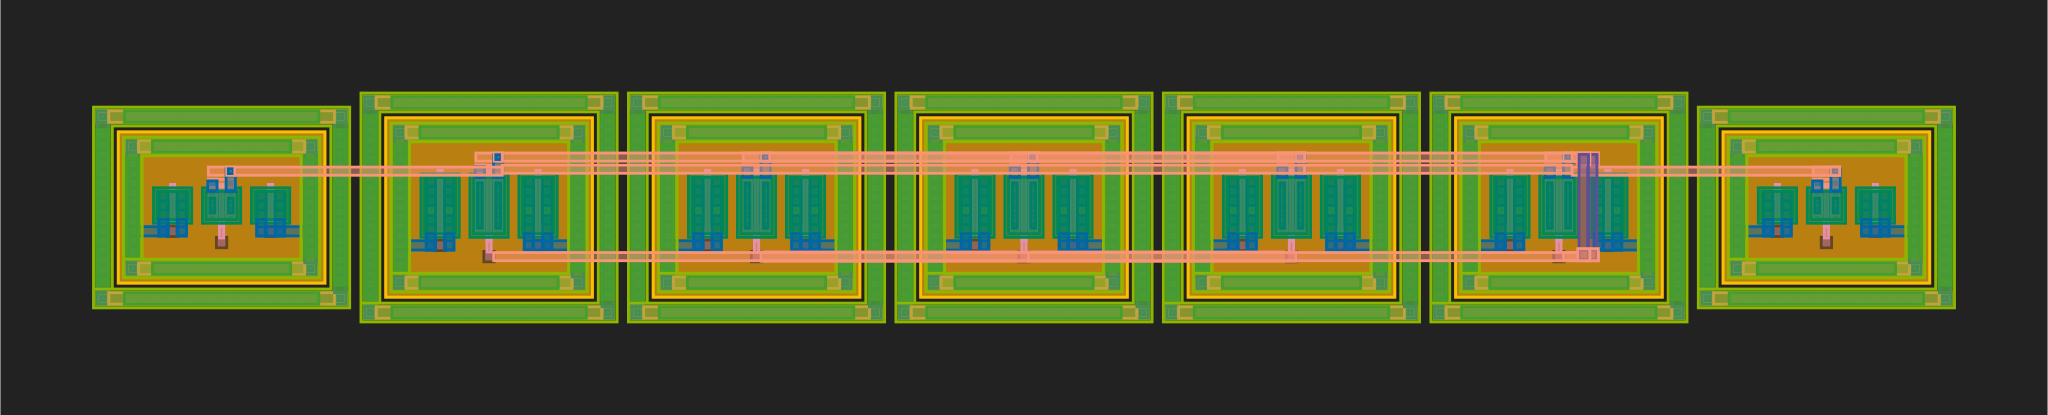

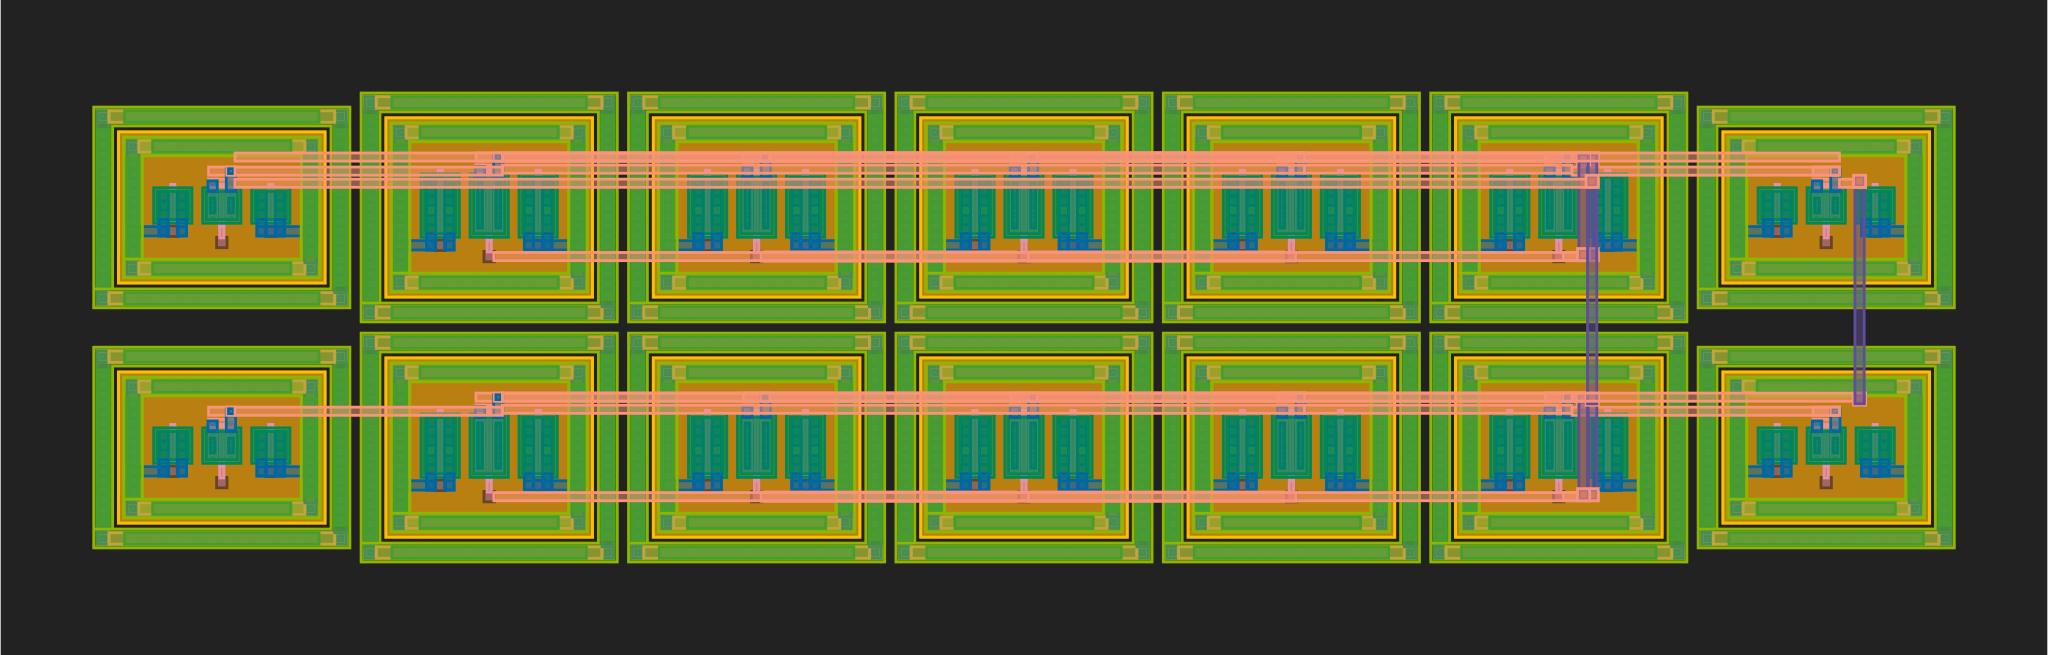

<ipython-input-8-7f8b86e10f2f>:9: UserWarning: Unnamed cells, 7 in 'nmos_latch'
  latch.write_gds("latch.gds")
2024-12-02 13:39:09.268 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'latch.gds'
<ipython-input-8-7f8b86e10f2f>:10: UserWarning: Unnamed cells, 14 in 'divide_by_two'
  divider.write_gds("divide_two.gds")
2024-12-02 13:39:09.283 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'divide_two.gds'


PosixPath('divide_two.gds')

In [8]:
# Create and display the designs
latch = create_nmos_latch_layout(sky130)
display_component(latch, scale=3)

divider = create_divide_by_two_circuit(sky130)
display_component(divider, scale=3)

# Save GDS files
latch.write_gds("latch.gds")
divider.write_gds("divide_two.gds")